<a href="https://colab.research.google.com/github/Sunflower47/Portfolio/blob/main/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задание

##Теория

В задании вы сами реализуете несколько алгоритмов оптимизации и примените их к определению космологических параметров Вселенной: параметра Хаббла и доли темной энергии в составе Вселенной.

Вам дан файл jla_mub.txt, содержащий две колонки: красное смещение сверхновых и модуль расстояния до них (см. заметку о космологическом красном смещении). Модуль расстояния μ задается следующим соотношением:
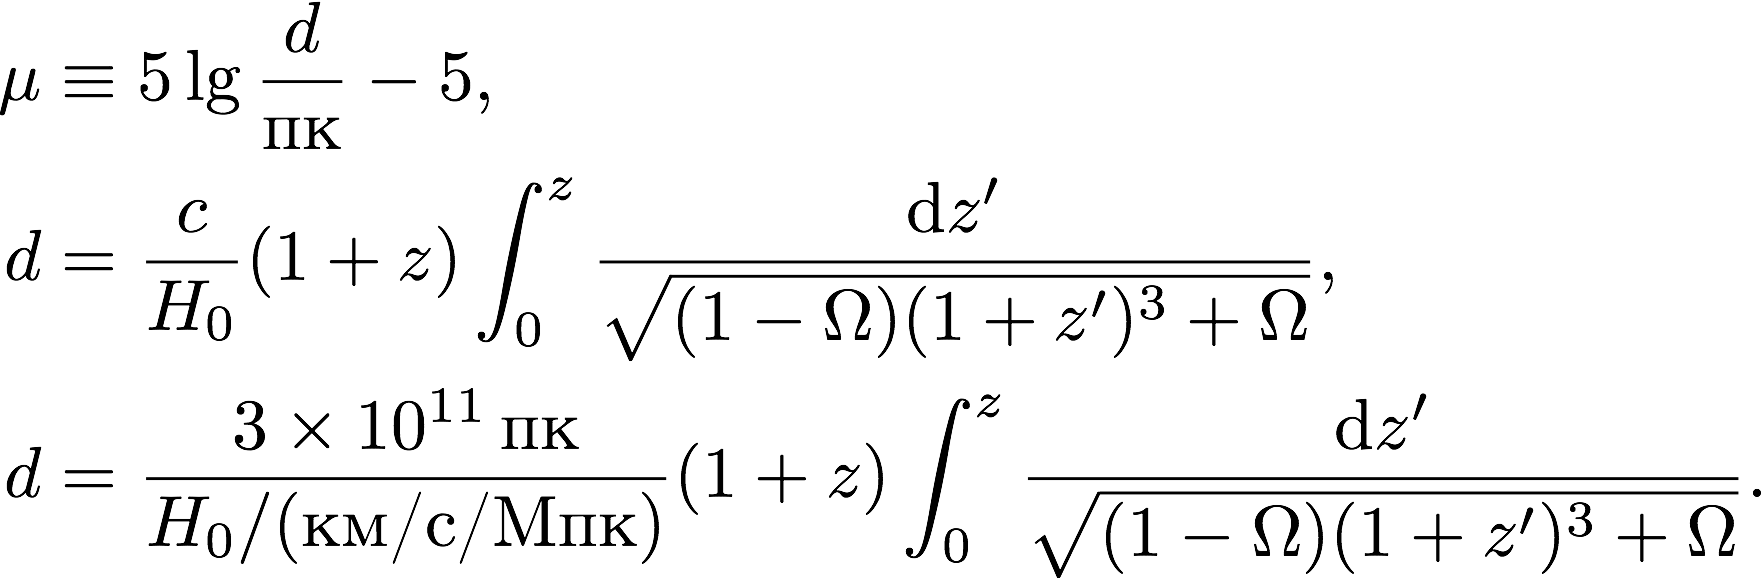

Здесь

- z — красное смещение,

- d — это фотометрическое расстояние,

- c — скорость света,

- H_0 — постоянная Хаббла (обычно выражается в км/с/Мпк),

- Ω — доля темной энергии в составе Вселененной (от 0 до 1).




##Реализация алгоритмов

Вы должны реализовать следующие алгоритмы в файле opt.py:


Метод Гаусса—Ньютона в виде функции gauss_newton(y, f, j, x0, k=1, tol=1e-4), где

  - y — это массив с измерениями,

  - f(*x) — это функция от неивестных параметров, возвращающая значения, 
рассчитанные в соответствии с моделью, в виде одномерного массива размера y.
size,

  - (*x) — это функция от неизвестных параметров, возвращающая якобиан в виде двумерного массива (y.size, x0.size),

  - x0 — массив с начальными приближениями параметров,

  - k — положительное число меньше единицы, параметр метода,

  - tol — относительная ошибка, условие сходимости, параметр метода.

Функция должна возвращать объект класса Result, реализованного в файле opt.py

Метод Левенберга—Марквардта в фиде функции lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4), где все одноимённые аргументы имеют те же значения, что и для gauss_newton,

- lmbd0 — начальное значение парметра lambda метода,

- nu — мультипликатор для параметра lambda.

Функция должна возвращать объект класса Result

##Код

##Импорт библиотек

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import json
from collections import namedtuple

##Распаковка данных

In [18]:
with open('jla_mub.txt', 'r', encoding='utf8')as f:
  text = f.read()


table = text.split('\n')
table = table[1:len(table) - 1]
z = []
mu = []

for lines in table:
  z.append(float(lines.split()[0]))
  mu.append(float(lines.split()[1]))

z = np.array(z)
mu = np.array(mu)

##Задание функций

Подыинтегральная функция для d

In [19]:
def func(z0, omega):
  return ((1 - omega)*(1 + z0)**3 + omega)**(-0.5)

Функция d массив

In [20]:
def d(l, H, omega):
   return np.array([(3*10**11/H)*(1 + z0)*quad(func, 0, z0, args=omega)[0] 
                    for z0 in l])

Функция μ

In [21]:
def mu_func(z0, H, omega):
  return 5*np.log10(d(z0, H, omega)) - 5

Подынтегральная функция для производной dμ/dΩ

In [22]:
def der_f_integ(z0, omega):
  return 0.5*(-1 + (1+z0)**3)*((1 - omega)*(1 + z0)**3 + omega)**(-3/2)

Производная dμ/dΩ

In [23]:
def der_mu(l, omega):
  return [5*quad(der_f_integ, 0, z0, args=omega)[0]/(np.log(10)*quad(func, 0, z0, args=omega)[0])
          for z0 in l]

Якобиан

In [24]:
def jacob(z, H, omega):
  arg = (H, omega)
  jac = np.empty((z.size, 2))
  jac[:, 0] = -5/(H*np.log(10))
  jac[:, 1] = np.array(der_mu(z, omega))
  return jac

Result = namedtuple('Result', ('nfev', 'cost', 'grandnorm', 'x'))

##Реализация метода Гаусса-Ньютона

In [25]:
def gauss_newton(y, f, j, x0, k=1, tol=1e-4):
  x = np.asarray(x0)
  i = 0
  cost = []
  while True:
    i += 1
    res = y - f(z, *x)
    cost.append(0.5 * np.dot(res, res))
    jac = j(z, *x)
    g = jac.T@res
    delta_x = np.linalg.inv(jac.T @ jac) @ g
    x = x + k * delta_x
    if np.linalg.norm(delta_x) <= tol * np.linalg.norm(x):
            break
  cost = np.array(cost)
  return Result(nfev=i, cost=cost, grandnorm=np.linalg.norm(x), x=x)

Начальные приближения

In [ ]:
H0 = (50, 0.5)
a = gauss_newton(mu, mu_func, jacob, H0)
xd = a.x
gauss_newton(mu, mu_func, jacob, H0)

Визуализация

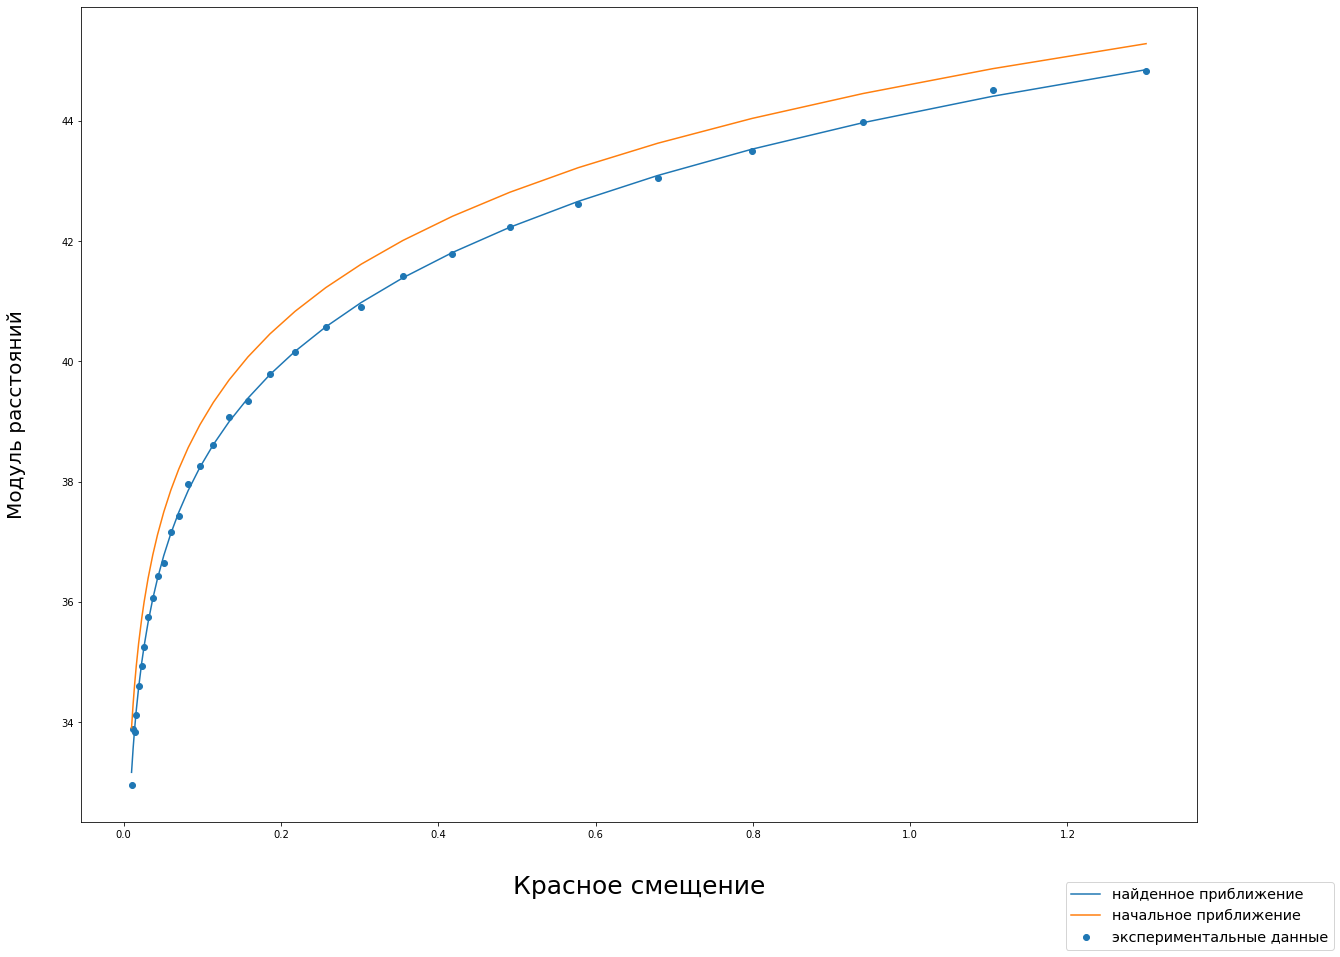

In [27]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
fig.get_dpi
plt.plot(z, mu_func(z, *xd), label='найденное приближение')
plt.plot(z, mu_func(z, *H0), label='начальное приближение')
plt.scatter(z, mu, label='экспериментальные данные')
fig.legend(fontsize='x-large', loc='lower right')
plt.ylabel('Модуль расстояний', fontsize=20, labelpad=35)
plt.xlabel('Красное смещение', fontsize=25, labelpad=35)
fig.savefig('mu-z.png')

##Реализация метода Левенберга—Марквардта

In [28]:
def lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4):
  x = np.asarray(x0)
  i = 0
  cost = []
  while True:
    i += 1
    res = -f(z, *x) + y
    F = 0.5 * np.dot(res, res)
    cost.append(F)
    jac = j(z, *x)
    g = jac.T@res

    delta_x1 = np.linalg.inv(jac.T @ jac + lmbd0 * np.eye(2)) @ g                          
    delta_x2 = np.linalg.inv(jac.T @ jac + (lmbd0/nu) * np.eye(2)) @ g     

    x1 = x + delta_x1
    x2 = x + delta_x2

    res_new1 = -f(z, *x1) + y
    F_new1 = 0.5 * np.dot(res_new1, res_new1)
    res_new2 = -f(z, *x2) + y
    F_new2 = 0.5 * np.dot(res_new2, res_new2)
    if F_new2 <= F:
      lmbd0 /= nu
      x = x2
      delta_x = delta_x2
    elif F_new2 > F and F_new2 <= F_new1:
      x = x1
      delta_x = delta_x1
    elif F_new2 > F and F_new2 > F_new1:
      lmbd0 *= nu

    if np.linalg.norm(delta_x) <= tol * np.linalg.norm(x):
            break
  cost = np.array(cost)
  return Result(nfev=i, cost=cost, grandnorm=np.linalg.norm(x), x=x)

Рассчет 

In [29]:
b = lm(mu, mu_func, jacob, H0)

Визуализация

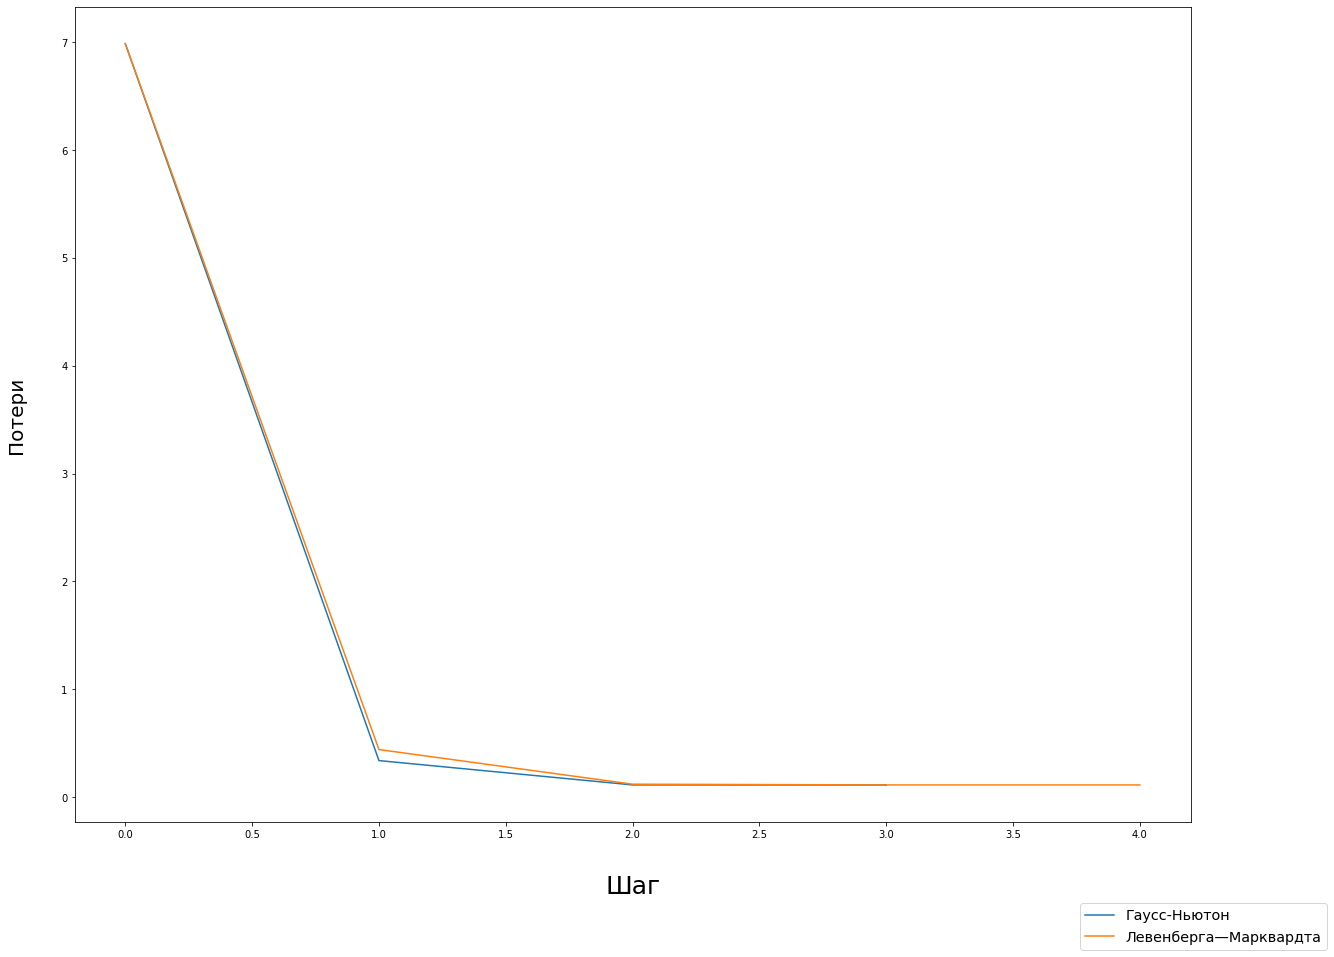

In [30]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
fig.get_dpi
plt.plot(np.arange(a.nfev), a.cost , label='Гаусс-Ньютон')
plt.plot(np.arange(b.nfev), b.cost , label='Левенберга—Марквардта')
fig.legend(fontsize='x-large', loc='lower right')
plt.ylabel('Потери', fontsize=20, labelpad=35)
plt.xlabel('Шаг', fontsize=25, labelpad=35)
fig.savefig('cost.png')


##Сохранение json

In [31]:
json_data = {
  "Gauss-Newton": {"H0": round(a.x[0]), "Omega": float(a.x[1]), "nfev": int(a.nfev)},
  "Levenberg-Marquardt": {"H0": round(b.x[0]), "Omega": float(b.x[1]), "nfev": int(b.nfev)}
            }

with open ('parameters.json', 'w') as f:
  json.dump(json_data, f)